In [1]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Bidirectional, Conv2D, MaxPooling2D, Lambda, MaxPool2D, BatchNormalization, Input, concatenate, K, Reshape, LSTM, CuDNNLSTM
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import xml.etree.ElementTree as ET
import sklearn
import itertools
import cv2
import scipy
import os
import csv
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm

Using TensorFlow backend.


In [2]:
class1 = {1:'NEUTROPHIL',2:'EOSINOPHIL',3:'MONOCYTE',4:'LYMPHOCYTE'}
class2 = {0:'Mononuclear',1:'Polynuclear'}
tree_path = '../input/dataset-master/dataset-master/Annotations'
image_path = '../input/dataset-master/dataset-master/JPEGImages'

In [3]:
#Sample image generation
image = cv2.imread(image_path+'/BloodImage_00002.jpg')
tree = ET.parse(tree_path+'/BloodImage_00002.xml')
try:
    image.shape
    print("Checked for shape. Shape is {}".format(image.shape))
except AttributeError:
    print("Error: Invalid shape.")

Checked for shape. Shape is (480, 640, 3)


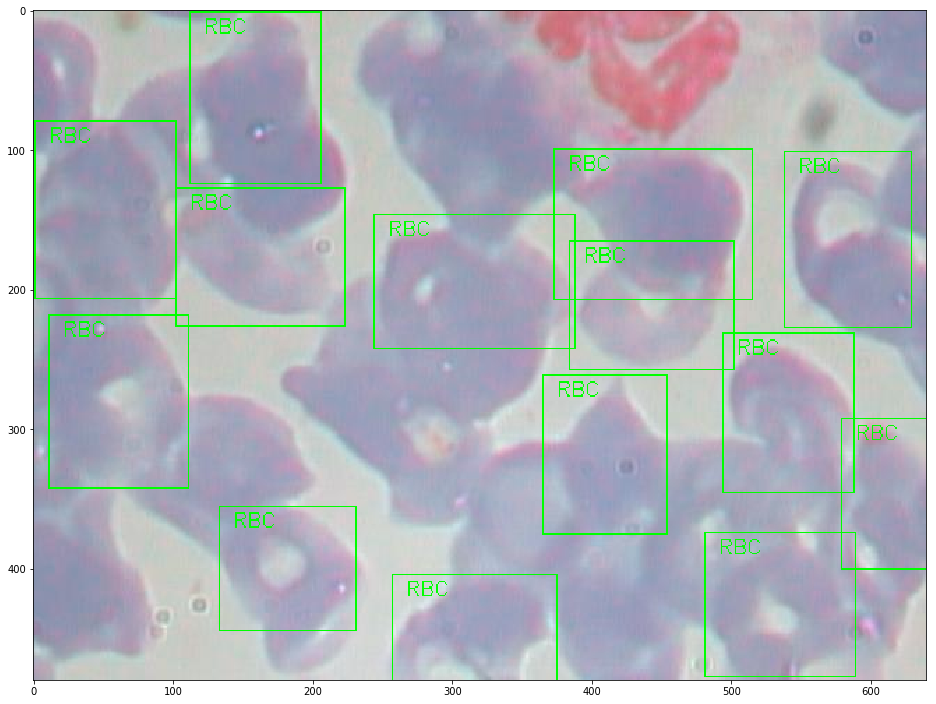

In [4]:
for elem in tree.iter():
    if 'object' in elem.tag or 'part' in elem.tag:
        for attr in list(elem):
            if 'name' in attr.tag:
                name = attr.text
            if 'bndbox' in attr.tag:
                for dim in list(attr):
                    if 'xmin' in dim.tag:
                        xmin = int(round(float(dim.text)))
                    if 'ymin' in dim.tag:
                        ymin = int(round(float(dim.text)))
                    if 'xmax' in dim.tag:
                        xmax = int(round(float(dim.text)))
                    if 'ymax' in dim.tag:
                        ymax = int(round(float(dim.text)))
                if name[0] == "R":
                    cv2.rectangle(image, (xmin, ymin),
                                (xmax, ymax), (0, 255, 0), 1)
                    cv2.putText(image, name, (xmin + 10, ymin + 15),
                            cv2.FONT_HERSHEY_SIMPLEX, 1e-3 * image.shape[0], (0, 255, 0), 1)
                if name[0] == "W":
                    cv2.rectangle(image, (xmin, ymin),
                                (xmax, ymax), (0, 0, 255), 1)
                    cv2.putText(image, name, (xmin + 10, ymin + 15),
                            cv2.FONT_HERSHEY_SIMPLEX, 1e-3 * image.shape[0], (0, 0, 255), 1)
                if name[0] == "P":
                    cv2.rectangle(image, (xmin, ymin),
                                (xmax, ymax), (255, 0, 0), 1)
                    cv2.putText(image, name, (xmin + 10, ymin + 15),
                            cv2.FONT_HERSHEY_SIMPLEX, 1e-3 * image.shape[0], (255, 0, 0), 1)
plt.figure(figsize=(16,16))
plt.imshow(image)
plt.show()

In [5]:
df1 = pd.read_csv('../input/dataset-master/dataset-master/labels.csv')
df1 = df1.drop(columns=['Unnamed: 0']).dropna()
df1

,Image,Category
0,0,NEUTROPHIL
1,1,NEUTROPHIL
2,2,NEUTROPHIL
3,3,NEUTROPHIL
4,4,NEUTROPHIL
5,5,NEUTROPHIL
6,6,NEUTROPHIL
7,7,NEUTROPHIL
8,8,BASOPHIL
9,9,EOSINOPHIL


In [6]:
#reader = csv.reader(open('/dataset-master/labels.csv'))
# skip thev header
y3 = df1[~df1["Category"].str.contains(",", na=False)]['Category']
y3

0      NEUTROPHIL
1      NEUTROPHIL
2      NEUTROPHIL
3      NEUTROPHIL
4      NEUTROPHIL
5      NEUTROPHIL
6      NEUTROPHIL
7      NEUTROPHIL
8        BASOPHIL
9      EOSINOPHIL
11     NEUTROPHIL
12     NEUTROPHIL
13     NEUTROPHIL
14     NEUTROPHIL
15       MONOCYTE
16     NEUTROPHIL
17     EOSINOPHIL
18     NEUTROPHIL
19     NEUTROPHIL
20     LYMPHOCYTE
21     LYMPHOCYTE
22     NEUTROPHIL
23     EOSINOPHIL
24     NEUTROPHIL
26     EOSINOPHIL
28     EOSINOPHIL
29     NEUTROPHIL
30     NEUTROPHIL
32     NEUTROPHIL
33     NEUTROPHIL
          ...    
376    EOSINOPHIL
377    NEUTROPHIL
378    NEUTROPHIL
379    NEUTROPHIL
381    NEUTROPHIL
382    NEUTROPHIL
383    EOSINOPHIL
384    NEUTROPHIL
385    NEUTROPHIL
386    NEUTROPHIL
387    EOSINOPHIL
388    NEUTROPHIL
389    NEUTROPHIL
390    NEUTROPHIL
391    NEUTROPHIL
392    NEUTROPHIL
393    NEUTROPHIL
395    NEUTROPHIL
396    NEUTROPHIL
397    NEUTROPHIL
398    NEUTROPHIL
400    NEUTROPHIL
402    NEUTROPHIL
403    NEUTROPHIL
404    NEU

[  3  88  33  21 207]


Text(0,0.5,'Number of Cells')

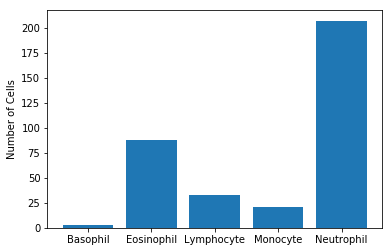

In [7]:
encoder = LabelEncoder()
encoder.fit(y3)
encoded_y = encoder.transform(y3)
counts = np.bincount(encoded_y)
print(counts)
fig, ax = plt.subplots()
plt.bar(list(range(5)), counts)
ax.set_xticklabels(('', 'Basophil', 'Eosinophil', 'Lymphocyte', 'Monocyte', 'Neutrophil'))
ax.set_ylabel('Number of Cells')

In [8]:
def get_data(folder):
    #    Load the data and labels from the given folder.
    X = []
    y = []
    z = []
    for wbc_type in os.listdir(folder):
        print(wbc_type)
        if not wbc_type.startswith('.'):
            if wbc_type in ['NEUTROPHIL']:
                label = 1
                label2 = 1
            elif wbc_type in ['EOSINOPHIL']:
                label = 2
                label2 = 1
            elif wbc_type in ['MONOCYTE']:
                label = 3  
                label2 = 0
            elif wbc_type in ['LYMPHOCYTE']:
                label = 4 
                label2 = 0
            else:
                label = 5
                label2 = 0
            for image_filename in tqdm(os.listdir(folder + wbc_type)):
                img_file = cv2.imread(folder + wbc_type + '/' + image_filename)
                if img_file is not None:
                    img_file = cv2.resize(img_file, dsize=(80,60), interpolation=cv2.INTER_CUBIC)
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
                    z.append(label2)
    X = np.asarray(X)
    y = np.asarray(y)
    z = np.asarray(z)
    return X,y,z
X_train, y_train, z_train = get_data('../input/dataset2-master/dataset2-master/images/TRAIN/')
X_test, y_test, z_test = get_data('../input/dataset2-master/dataset2-master/images/TEST/')

# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
from keras.utils.np_utils import to_categorical
y_trainHot = to_categorical(y_train, num_classes = 5)
y_testHot = to_categorical(y_test, num_classes = 5)
z_trainHot = to_categorical(z_train, num_classes = 2)
z_testHot = to_categorical(z_test, num_classes = 2)
print(class1)
print(class2)

  0%|          | 0/2497 [00:00<?, ?it/s]

EOSINOPHIL


  1%|▏         | 34/2478 [00:00<00:07, 333.76it/s]

MONOCYTE


  1%|          | 29/2499 [00:00<00:08, 289.61it/s]

NEUTROPHIL


  1%|▏         | 35/2483 [00:00<00:07, 345.33it/s]

LYMPHOCYTE


  5%|▌         | 34/623 [00:00<00:01, 335.67it/s]

EOSINOPHIL


  6%|▌         | 35/620 [00:00<00:01, 342.48it/s]

MONOCYTE


  5%|▌         | 34/624 [00:00<00:01, 333.79it/s]

NEUTROPHIL


  5%|▌         | 32/620 [00:00<00:01, 312.89it/s]

LYMPHOCYTE


100%|██████████| 620/620 [00:01<00:00, 329.34it/s]

{1: 'NEUTROPHIL', 2: 'EOSINOPHIL', 3: 'MONOCYTE', 4: 'LYMPHOCYTE'}
{0: 'Mononuclear', 1: 'Polynuclear'}


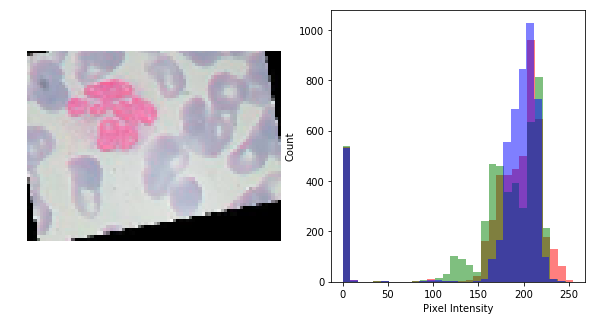

In [9]:
def plotHistogram(a):
    #Plot histogram of RGB Pixel Intensities
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.axis('off')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);
plotHistogram(X_train[1])

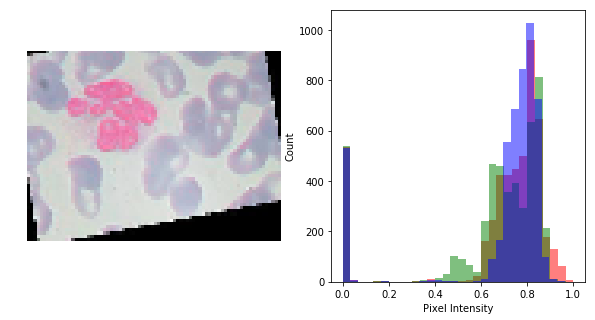

In [10]:
X_train=np.array(X_train)
X_train=X_train/255.0
X_test=np.array(X_test)
X_test=X_test/255.0
plotHistogram(X_train[1])

In [11]:
def rgb_to_grayscale(input):
    """Average out each pixel across its 3 RGB layers resulting in a grayscale image"""
    return K.mean(input, axis=3)
def rgb_to_grayscale_output_shape(input_shape):
    return input_shape[:-1]

In [12]:
# Helper Functions  Learning Curves and Confusion Matrix
class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
#This function prints and plots the confusion matrix.
#Normalization can be applied by setting `normalize=True`.

    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    #plt.clf()
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

In [13]:
def runKerasCNNAugment(a,b,c,d,e, epochs, classes):
    
    batch_size = 128
    num_classes = len(b[0])
#     img_rows, img_cols = a.shape[1],a.shape[2]
    img_rows,img_cols=60,80
    input_shape = (img_rows, img_cols, 3)
    input_tensor = Input(shape=input_shape)
    
    #Creating CNN
    modelcnn = Sequential()
    modelcnn.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape,strides=e))
    modelcnn.add(Conv2D(64, (3, 3), activation='relu'))
    modelcnn.add(MaxPooling2D(pool_size=(2, 2)))
    modelcnn.add(Dropout(0.25))
    modelcnn.add(Flatten())
    cnn_output = modelcnn(input_tensor)
    
    # Creating RNN    
    modelrnn = Lambda(rgb_to_grayscale, rgb_to_grayscale_output_shape)(input_tensor)
    #modelrnn = Bidirectional(LSTM(64, return_sequences=True, dropout=0.25, recurrent_dropout=0.25))(modelrnn)
    #rnn_output = Bidirectional(LSTM(64, dropout=0.25, recurrent_dropout=0.25))(modelrnn)
    modelrnn = Bidirectional(CuDNNLSTM(64, return_sequences=True))(modelrnn)
    modelrnn = Dropout(0.25)(modelrnn)
    rnn_output = Bidirectional(CuDNNLSTM(64))(modelrnn)
    rnn_output = Dropout(0.25)(rnn_output)
    # Merging both cnn bottleneck and rnn's output wise element wise multiplication
    merge_layer = concatenate([cnn_output, rnn_output])
    last_process = Dense(128, activation='relu')(merge_layer)
    last_process = Dropout(0.5)(last_process)
    output_tensor = Dense(num_classes, activation='softmax')(last_process)
    model = Model(input=input_tensor, output=output_tensor)
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])    
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zoom_range=0.1,
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False
        )  # randomly flip images
    history = model.fit_generator(datagen.flow(a,b, batch_size=32,shuffle=True), steps_per_epoch=len(a) / 32, epochs=epochs, validation_data = [c, d],callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN+RNN accuracy:', score[1],'\n')
    y_pred = model.predict(c)
    map_characters = classes
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
    Y_pred_classes = np.argmax(y_pred,axis=1) 
    Y_true = np.argmax(d,axis=1)
    plotKerasLearningCurve()
    plt.show()  
    plot_learning_curve(history)
    plt.show()
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(classes.values())) 
    plt.show()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Epoch 1/70
312/311 [==============================] - 21s 68ms/step - loss: 1.4645 - acc: 0.2641 - val_loss: 1.3661 - val_acc: 0.3132
Epoch 2/70
312/311 [==============================] - 16s 51ms/step - loss: 1.3554 - acc: 0.3258 - val_loss: 1.2605 - val_acc: 0.3989
Epoch 3/70
312/311 [==============================] - 16s 50ms/step - loss: 1.2963 - acc: 0.3754 - val_loss: 1.1590 - val_acc: 0.4970
Epoch 4/70
312/311 [==============================] - 16s 51ms/step - loss: 1.2323 - acc: 0.4204 - val_loss: 1.2090 - val_acc: 0.4331
Epoch 5/70
312/311 [==============================] - 17s 54ms/step - loss: 1.1655 - acc: 0.4597 - val_loss: 1.0873 - val_acc: 0.5328
Epoch 6/70
312/311 [==============================] - 16s 51ms/step - loss: 1.0993 - acc: 0.5162 - val_loss: 1.7079 - val_acc: 0.2505
Epoch 7/70
312/311 [==============================] - 16s 50ms/step - loss: 0.9741 - acc: 0.5646 - val_loss: 0.9317 - val_acc: 0.5119
Epoch 8/70
312/311 [==============================] - 16s 53ms

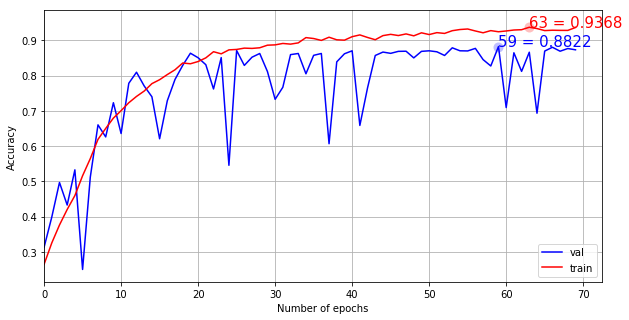

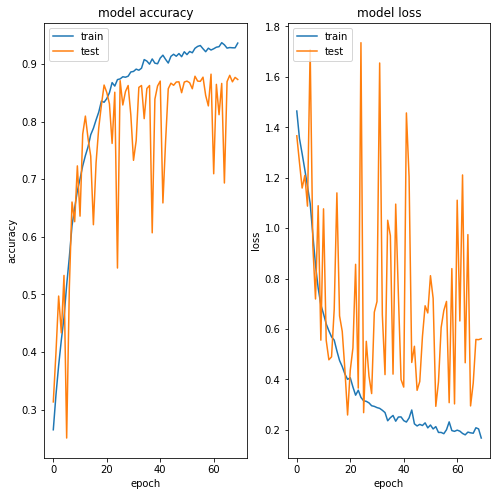

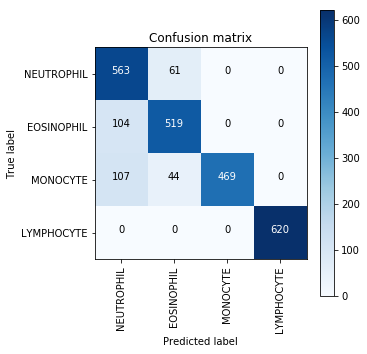

In [14]:
runKerasCNNAugment(X_train,y_trainHot,X_test,y_testHot,1,70, class1)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Epoch 1/70
312/311 [==============================] - 16s 52ms/step - loss: 0.7013 - acc: 0.5000 - val_loss: 0.6932 - val_acc: 0.5030
Epoch 2/70
312/311 [==============================] - 14s 46ms/step - loss: 0.6931 - acc: 0.5116 - val_loss: 0.6866 - val_acc: 0.5384
Epoch 3/70
312/311 [==============================] - 15s 47ms/step - loss: 0.6788 - acc: 0.5749 - val_loss: 0.7145 - val_acc: 0.5014
Epoch 4/70
312/311 [==============================] - 14s 46ms/step - loss: 0.6356 - acc: 0.6369 - val_loss: 1.2531 - val_acc: 0.4986
Epoch 5/70
312/311 [==============================] - 15s 48ms/step - loss: 0.5438 - acc: 0.7280 - val_loss: 0.5880 - val_acc: 0.6647
Epoch 6/70
312/311 [==============================] - 15s 49ms/step - loss: 0.4678 - acc: 0.7738 - val_loss: 0.4835 - val_acc: 0.7334
Epoch 7/70
312/311 [==============================] - 14s 46ms/step - loss: 0.4161 - acc: 0.8095 - val_loss: 0.4403 - val_acc: 0.7994
Epoch 8/70
312/311 [==============================] - 14s 46ms

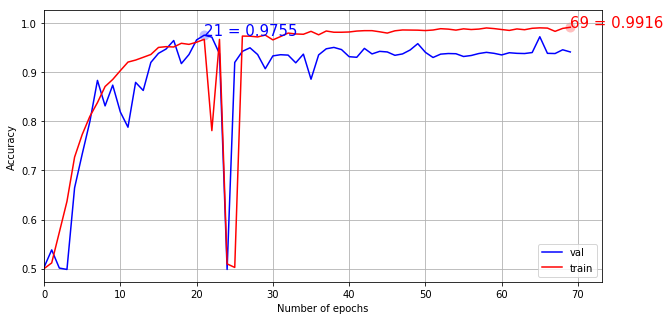

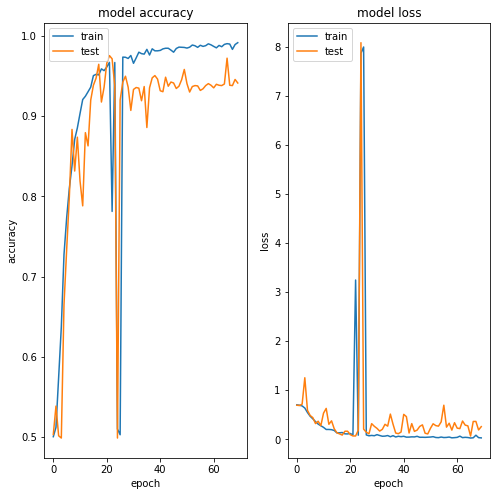

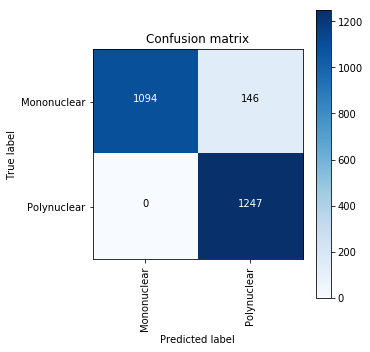

In [15]:
runKerasCNNAugment(X_train,z_trainHot,X_test,z_testHot,2, 70, class2)